# Influence Of Dykes On River Network System Graph Metrics - An Analysis With FastScape

Author: Malte Springer

Project for ESPM 2025

In [1]:
############### Modules ###############

# --- Basics ---
import os
import glob
from pathlib import Path
import pickle
from tqdm import tqdm, trange
from pympler import asizeof # part of testing procedures for memory usage


# --- Math and arrays ---
import numpy as np
import xarray as xr
import pandas as pd

# --- Plotting ---
import matplotlib
import matplotlib.pyplot as plt

# --- Efficiency ---
from joblib import Parallel, delayed

# --- FastScape ---
import xsimlab as xs
import fastscape 
from fastscape.models import basic_model 
from fastscape.models import sediment_model 
from fastscape.processes import FlowAccumulator

# --- Network/Graph Analysis ---
import networkx as netx


c:\Users\MS\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Import the helper functions that run the simulation and analysis process

from Fastscape_River_Graphs import *

### 1. Set up the model with parameters

In [3]:
%load_ext xsimlab.ipython

model_sed = sediment_model.update_processes({'drainage': FlowAccumulator})

In [8]:
# Model Parameters - will be used in each of the different simulation runs

# Simulation shape twice as wide as high
nx,ny = 201, 101
xl,yl = 40e3, 20e3
x,y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny))

x = xr.DataArray(x, dims=('y', 'x'))
y = xr.DataArray(y, dims=('y', 'x'))

# Set very long time span with sufficiently low simulation resolution to be efficient and save memory
tf = 10e7
tstep = xr.DataArray(np.linspace(0,tf,401), dims='tstep')
time = xr.DataArray(np.linspace(0,tf,21), dims='time')

# Pick a field for precipitation, not really essential to this modelling
precip_base_arr = np.ones([ny, nx])
precip_base_arr=precip_base_arr*5
xr_2d = xr.DataArray(np.ones((ny,nx)), dims=['y','x'])
precip_base_xr=xr_2d*5

In [9]:
# %create_setup model_sed
ds_in_sed = xs.create_setup(
    model=model_sed,
    clocks={'tstep':tstep, 'time':time},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny, nx], 
        'grid__length': [yl, xl],  
        'boundary__status': ['fixed_value', 'fixed_value', 'looped', 'looped'], # Looped for north and south edges to align well with the dyke later

        # Initial parameters chosen as described in the text document

        'uplift__rate': 1e-4, 

        'init_topography__seed': None,

        'flow__slope_exp': 1.0,  

        'drainage__runoff': precip_base_xr,  

        'spl__area_exp': 0.5,  
        'spl__slope_exp': 1.0,  
        'spl__tol_rel': 1e-4,  
        'spl__tol_abs': 1e-6,  
        'spl__max_iter': 500,  

        'spl__k_coef_bedrock': 5e-6,  
        'spl__k_coef_soil': 1e-4,     

        'spl__g_coef_bedrock': 0.0,  
        'spl__g_coef_soil': 0.3,     

        'diffusion__diffusivity_bedrock': 0.0,  
        'diffusion__diffusivity_soil': 0.01,   
    },
    output_vars={
        'topography__elevation': 'time',
        'drainage__flowacc': 'time',
        'flow__basin': 'time',
    }
)

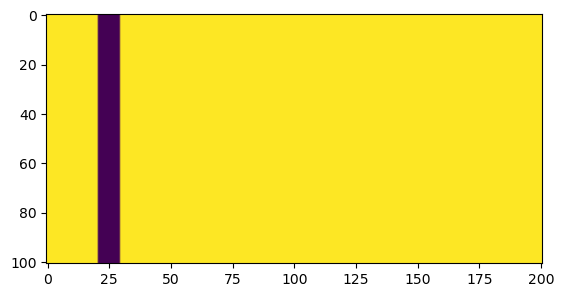

In [10]:
# Illustration of how the change in kf looks like

kf_new = xr.where((x-9.7e3)*(x-10.3e3)<0, 0.2e-5, 1e-5)

kf_new = (
                        xr.where(
                            (x < (x.max() / 2 - x.max() * 0.35)) & (x > (x.max() / 2 - x.max() * 0.4)),
                             0.2e-5, 1e-5
                        )
                    )

plt.imshow(kf_new)

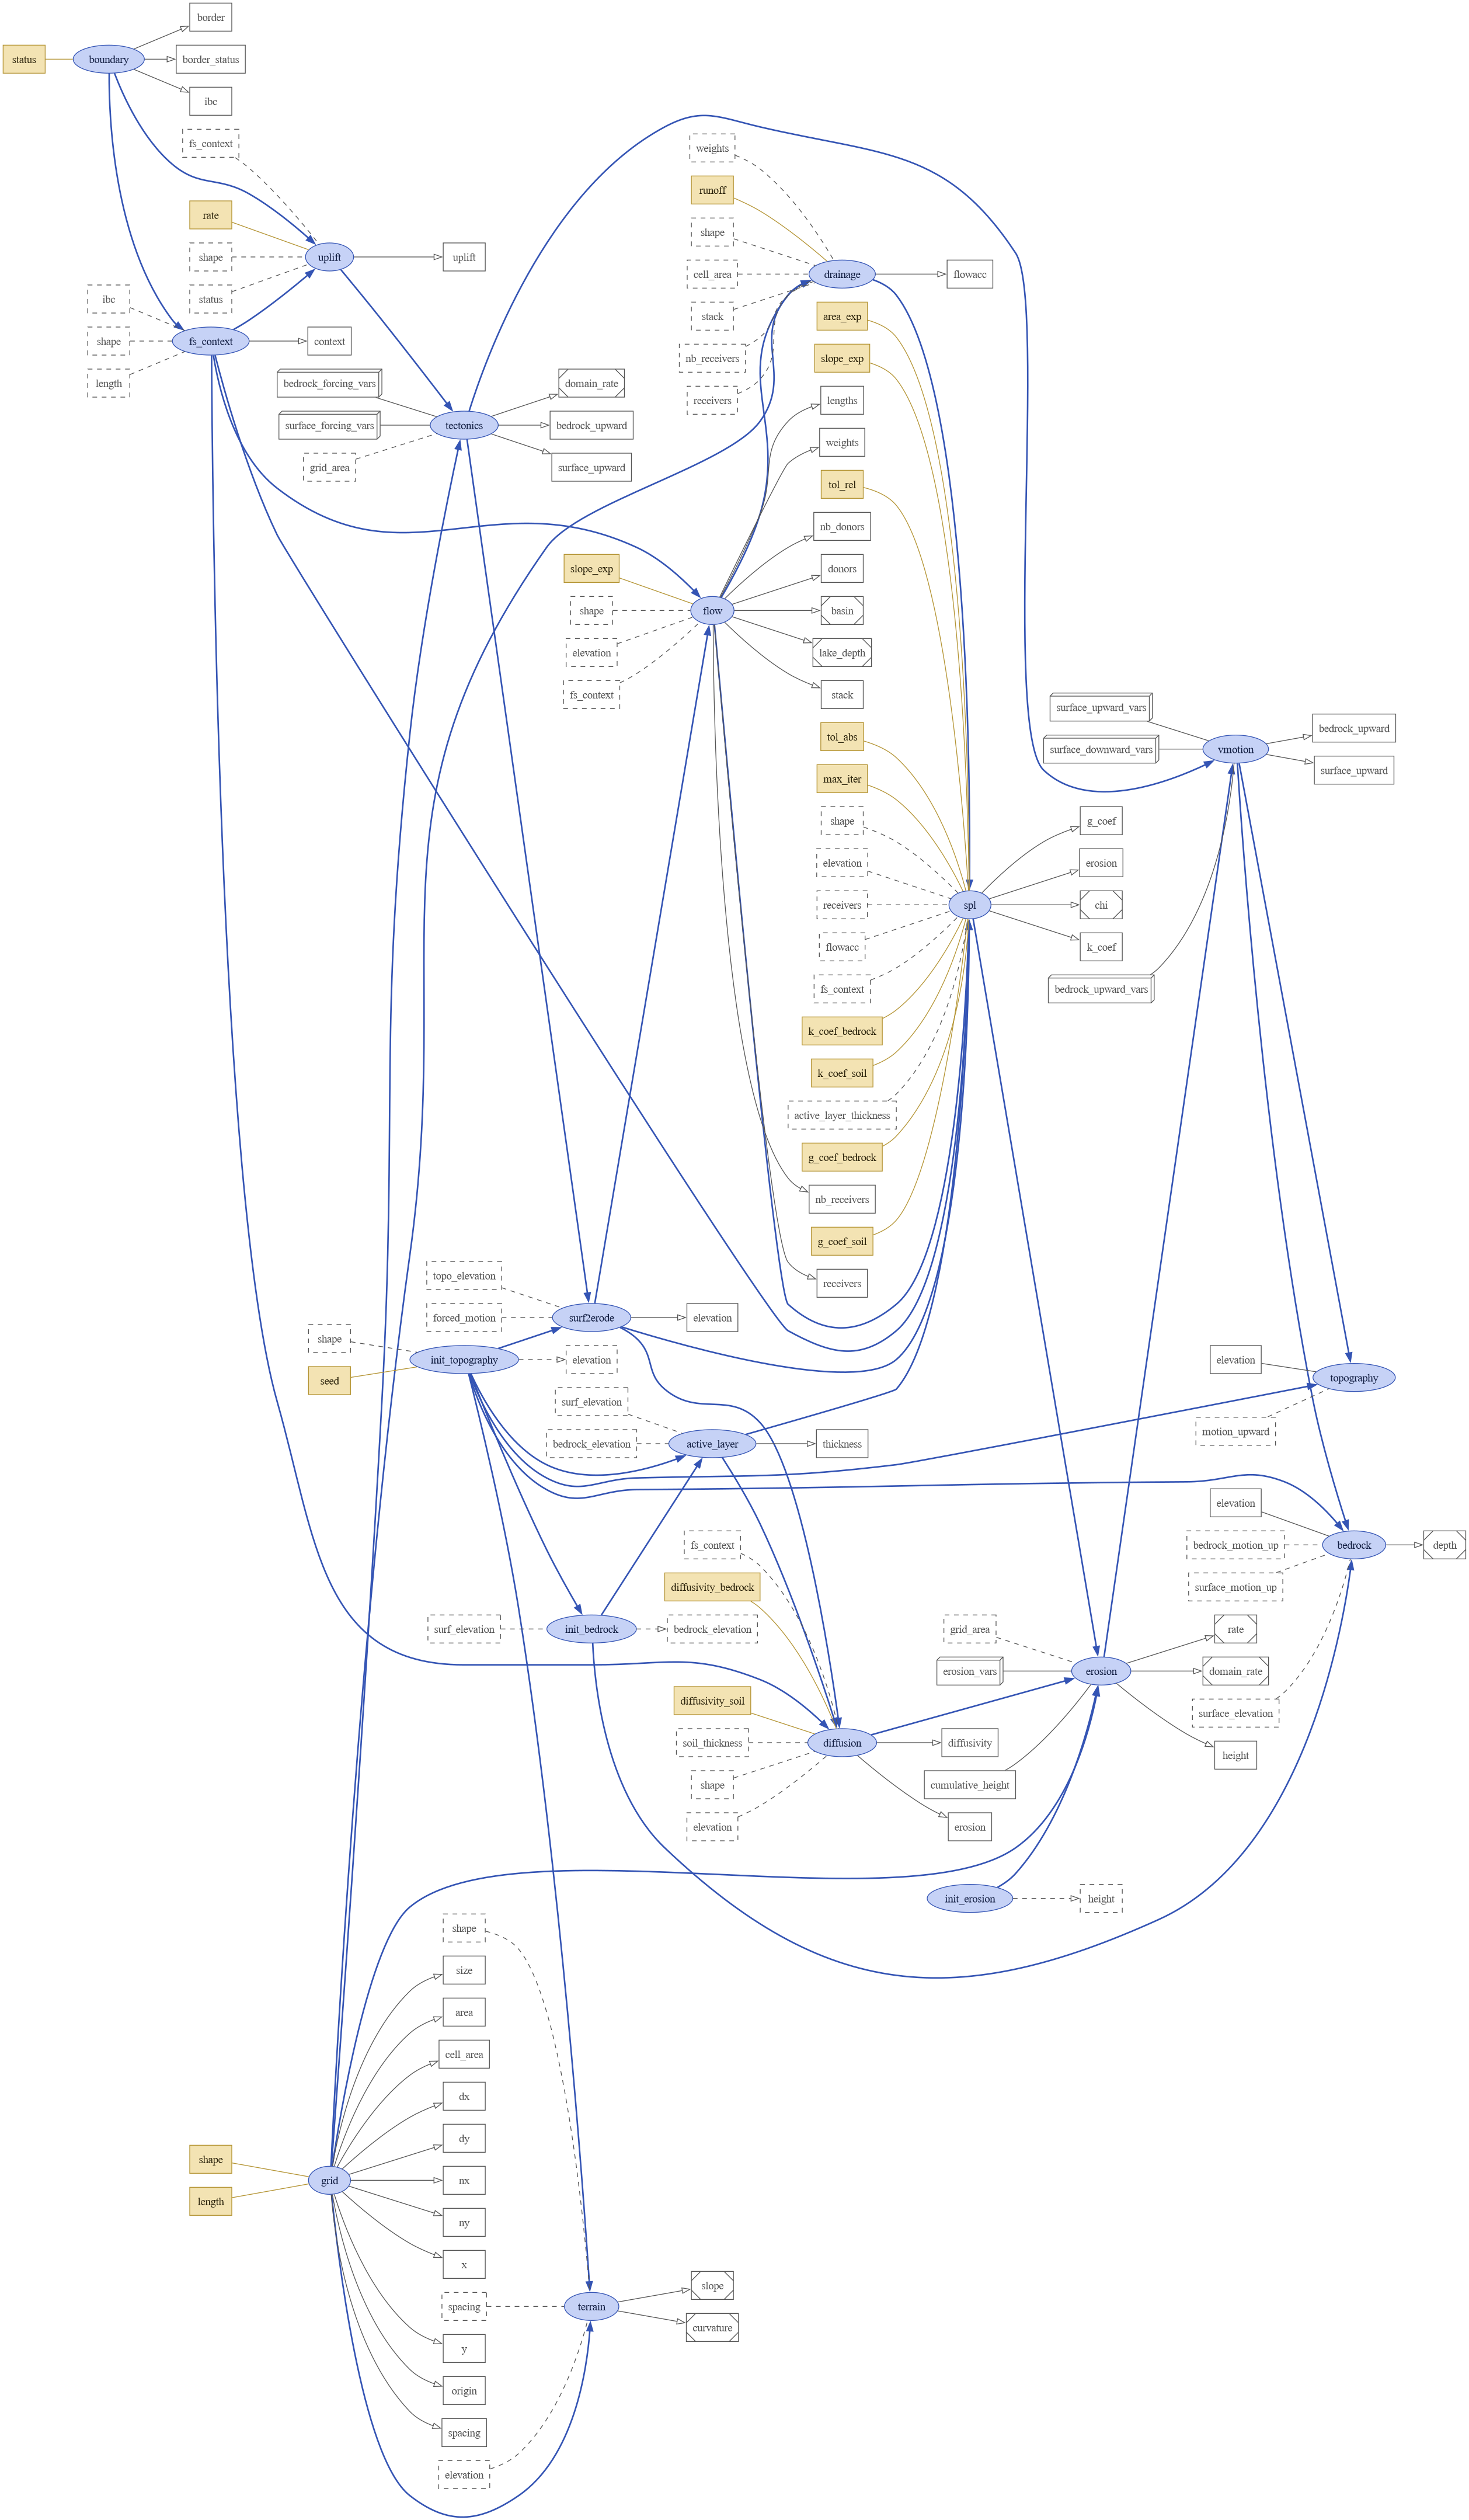

In [11]:
model_sed.visualize(show_inputs=True, show_variables=True)

### 2. Run the random fields experiment with the previously generated sediment model

In [10]:
# Execute the experiment

EXP1 = RandomFieldExperiment(x=x, y=y) # Initialize the object instance

EXP1.generate_fields(centres=[7500, 10000, 20000, 30000], thicknesses=[100, 1000, 2500, 5000],  kfs=np.logspace(-6, -4, 10), background_kf=1e-5) # generate a bunch of random fields for the parameters mentioned in the paper

EXP1.run_experiment(model=model_sed, ds_in=ds_in_sed, n_noises=100, n_jobs=-2, storage=r"F:\ESPM") # run and store the simulation result for 100 noises per parameter combination with highly parallelized version

100%|██████████| 160/160 [5:33:57<00:00, 125.23s/it]  


### 3. Analyze the results of the simulation

In [12]:
# Re-open the relevant data for the metric analysis

p = r"F:\ESPM"

with open(Path(p) / "EXP_test_field_dict.pkl", "rb") as f:
    EXP1_field_dict = pickle.load(f)

Found file_150_noise_0.nc


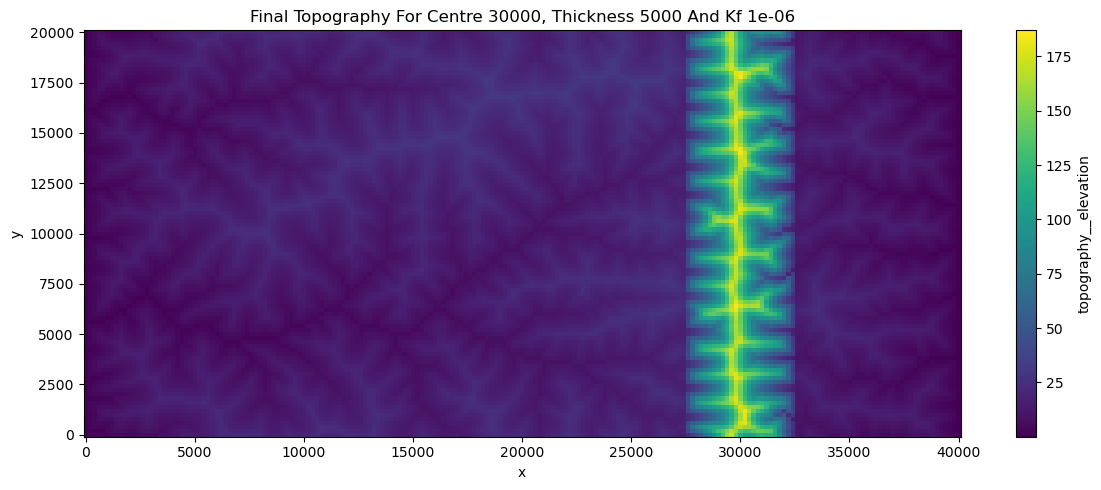

In [13]:
# Plot and check the final topography for one selected noise and parameter combination

_ = plot_sim_result(EXP1_field_dict, path=p, centre=30000, thickness=5000, kf_n=0, noise=0, visualize=True)

#### Generate the plots stored in the github plots folder

In [13]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='num_nodes', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)

Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.
c:\Users\MS\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 43.7min remaining:  4.9min


Completed: 160 OK, 0 ERROR


[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 47.1min finished


In [14]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='longest_path', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 46.6min remaining:  5.2min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 50.2min finished


In [15]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='diameter', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 66.5min remaining:  7.4min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 70.2min finished


In [16]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='radius', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 64.2min remaining:  7.1min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 68.4min finished


In [17]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='degree', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 65.0min remaining:  7.2min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 69.4min finished


In [18]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='betweenness_centrality', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 78.3min remaining:  8.7min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 82.8min finished


In [19]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='katz_centrality', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 60.5min remaining:  6.7min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 64.1min finished


In [20]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='eccentricity', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 63.2min remaining:  7.0min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 68.0min finished


In [21]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric="strahler", node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 60.4min remaining:  6.7min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 64.4min finished


In [22]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric="shreve", node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-4)]: Done  64 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-4)]: Done  79 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-4)]: Done  94 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-4)]: Done 111 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-4)]: Done 144 out of 160 | elapsed: 60.2min remaining:  6.7min


Completed: 160 OK, 0 ERROR
{'results': [{'i': 0, 'status': 'ok', 'df': None}, {'i': 1, 'status': 'ok', 'df': None}, {'i': 2, 'status': 'ok', 'df': None}, {'i': 3, 'status': 'ok', 'df': None}, {'i': 4, 'status': 'ok', 'df': None}, {'i': 5, 'status': 'ok', 'df': None}, {'i': 6, 'status': 'ok', 'df': None}, {'i': 7, 'status': 'ok', 'df': None}, {'i': 8, 'status': 'ok', 'df': None}, {'i': 9, 'status': 'ok', 'df': None}, {'i': 10, 'status': 'ok', 'df': None}, {'i': 11, 'status': 'ok', 'df': None}, {'i': 12, 'status': 'ok', 'df': None}, {'i': 13, 'status': 'ok', 'df': None}, {'i': 14, 'status': 'ok', 'df': None}, {'i': 15, 'status': 'ok', 'df': None}, {'i': 16, 'status': 'ok', 'df': None}, {'i': 17, 'status': 'ok', 'df': None}, {'i': 18, 'status': 'ok', 'df': None}, {'i': 19, 'status': 'ok', 'df': None}, {'i': 20, 'status': 'ok', 'df': None}, {'i': 21, 'status': 'ok', 'df': None}, {'i': 22, 'status': 'ok', 'df': None}, {'i': 23, 'status': 'ok', 'df': None}, {'i': 24, 'status': 'ok', 'df': No

[Parallel(n_jobs=-4)]: Done 160 out of 160 | elapsed: 64.2min finished


# DCI Tests

The workflow is capable of computing a DCI (Dyke Crossing Index) which tells if in a specific run by a specific graph the dyke was crossed/intercepted. The computation is pretty expensive but once its done, one can take the respective simulation values for dyke thickness, erodibility and distance to the centre of the simulation grid and see how these parameters influence the odds of producing a crossed dyke system.

In [23]:
out = simulation_analysis_joblib_callable(
    nx=nx, ny=ny, path=r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric=None, node_based=False, log=False, save_as=r"F:\ESPM\figs",
    limit=None, n_jobs=-4, backend="loky",
    SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=None,
    compute_dci=True, dci_use_details=True, save_df_path=r"F:\ESPM\dci.parquet",
    centre_grid_nx=40001,        # centres are 0..40000  → length 40001
    centre_mapping="extent",     # map into observed graph x-range
    progress="tqdm", verbose=10
)
df = out["dci_df"]

Launching joblib.Parallel with backend=loky, n_jobs=-4


fields (returned):   0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Completed: 160 OK, 0 ERROR


In [27]:
def z(x): return (x - x.mean()) / x.std(ddof=0)
df["logKf"] = np.log10(df["Kf"])
df["logKf_z"] = z(df["logKf"])
df["thickness_z"] = z(df["thickness"])
df["centre_z"] = z(df["centre"])

df.to_csv(r"F:\ESPM\results_df.csv")
df

,crossing,run_id,field_id,noise_id,centre,centre_field,thickness,Kf,logKf,logKf_z,thickness_z,centre_z
0,1,0_0,0,0,7500.0,7500.0,100.0,0.000001,-6.0,-1.565647,-1.103514,-1.050424
1,1,0_0,0,0,7500.0,7500.0,100.0,0.000001,-6.0,-1.565647,-1.103514,-1.050424
2,0,0_0,0,0,7500.0,7500.0,100.0,0.000001,-6.0,-1.565647,-1.103514,-1.050424
3,0,0_0,0,0,7500.0,7500.0,100.0,0.000001,-6.0,-1.565647,-1.103514,-1.050424
4,0,0_0,0,0,7500.0,7500.0,100.0,0.000001,-6.0,-1.565647,-1.103514,-1.050424
...,...,...,...,...,...,...,...,...,...,...,...,...
475422,0,159_99,159,99,30000.0,30000.0,5000.0,0.000100,-4.0,1.572458,1.540354,1.476541
475423,0,159_99,159,99,30000.0,30000.0,5000.0,0.000100,-4.0,1.572458,1.540354,1.476541
475424,0,159_99,159,99,30000.0,30000.0,5000.0,0.000100,-4.0,1.572458,1.540354,1.476541
475425,0,159_99,159,99,30000.0,30000.0,5000.0,0.000100,-4.0,1.572458,1.540354,1.476541


In [39]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM # from testing

def z(x): return (x - x.mean()) / x.std(ddof=0)

In [43]:
df = pd.read_csv(r"F:\ESPM\results_df.csv")

df["dist_centre"] = np.abs(df["centre"] - 20000)
df["dist_centre_z"] = z(df["dist_centre"])

df_run = (df.groupby("run_id", as_index=False)
            .agg(crossings=("crossing","sum"),
                 trials=("crossing","size"),
                 logKf_z=("logKf_z","mean"),        
                 thickness_z=("thickness_z","mean"),
                 dist_centre_z=("dist_centre_z","mean")))

In [44]:
df_run["prop"] = df_run["crossings"] / df_run["trials"]
X = sm.add_constant(df_run[["logKf_z","thickness_z", "dist_centre_z"]])
glm_binom = sm.GLM(df_run["prop"], X,
                   family=sm.families.Binomial(),
                   var_weights=df_run["trials"])   # weights = trials
res_glm = glm_binom.fit(cov_type="HC3")            # robust SEs
print(res_glm.summary())

# Odds ratios
b = res_glm.params; se = res_glm.bse
pd.DataFrame({
    "term": b.index,
    "OR": np.exp(b),
    "CI_lo": np.exp(b - 1.96*se),
    "CI_hi": np.exp(b + 1.96*se)
})

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   prop   No. Observations:                16000
Model:                            GLM   Df Residuals:                    15996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -72905.
Date:                Wed, 24 Sep 2025   Deviance:                       11269.
Time:                        21:30:46   Pearson chi2:                 9.66e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2457
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.9796      0.006   -510.767

,term,OR,CI_lo,CI_hi
const,const,0.050811,0.050234,0.051396
logKf_z,logKf_z,1.363485,1.350290,1.376808
thickness_z,thickness_z,0.829632,0.820527,0.838839
dist_centre_z,dist_centre_z,1.325901,1.309867,1.342132


In [45]:
# Different Implementation

dfm = df.loc[:, ["crossing","run_id","logKf_z","thickness_z","dist_centre_z"]].dropna().copy()
dfm["crossing"] = dfm["crossing"].astype(int)

X = sm.add_constant(dfm[["logKf_z","thickness_z", "dist_centre_z"]])
gee = GEE(endog=dfm["crossing"], exog=X, groups=dfm["run_id"],
          family=Binomial(), cov_struct=Exchangeable())
res = gee.fit()
print(res.summary())

# Odds ratios
b, se = res.params, res.bse
pd.DataFrame({
    "term": b.index,
    "OR": np.exp(b),
    "CI_lo": np.exp(b - 1.96*se),
    "CI_hi": np.exp(b + 1.96*se)
})


                               GEE Regression Results                              
Dep. Variable:                    crossing   No. Observations:               475427
Model:                                 GEE   No. clusters:                    16000
Method:                        Generalized   Min. cluster size:                  18
                      Estimating Equations   Max. cluster size:                  43
Family:                           Binomial   Mean cluster size:                29.7
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Wed, 24 Sep 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         21:30:56
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.9856      0.006   -509.760      0.000      -2.997      -2.97

,term,OR,CI_lo,CI_hi
const,const,0.050511,0.049935,0.051094
logKf_z,logKf_z,1.363578,1.350280,1.377007
thickness_z,thickness_z,0.830551,0.821420,0.839782
dist_centre_z,dist_centre_z,1.327399,1.311212,1.343786


In both implementations an increase in erodibility (by one standard deviation) increases the odds of a crossing occuring by 36%. An increase in dyke distance to the centre of the simulation grid increases the odds of a crossing occuring by about 32% while an increase in thickness leads to a reduction of the odds by about 17%. These results seem logical since a more erodible dyke is less resistant to river forces while a thicker dyke is harder to cross. The distance to the grid centre increases the likelihood for crossings since dykes which are mroe distant to the center face rivers with a larger upstream area which results in larger river forces.

### 4. Light-Weight Example With Plots (not reported in paper)

In [18]:
# Model Parameters - will be used in each of the different simulation runs

nx,ny = 201, 101
xl,yl = 40e3, 20e3
x,y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny))
tf = 10e7
tstep = xr.DataArray(np.linspace(0,tf,401), dims='tstep')
time = xr.DataArray(np.linspace(0,tf,201), dims='time')


precip_base_arr = np.ones([ny, nx])
precip_base_arr=precip_base_arr*5
xr_2d = xr.DataArray(np.ones((ny,nx)), dims=['y','x'])
precip_base_xr=xr_2d*5

In [19]:
# %create_setup model_sed
ds_in_sed = xs.create_setup(
    model=model_sed,
    clocks={'tstep':tstep, 'time':time},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny, nx], 
        'grid__length': [yl, xl],  
        'boundary__status': ['fixed_value', 'fixed_value', 'looped', 'looped'],

        'uplift__rate': 1e-4,  # m/year = 0.1 mm/yr, typical for tectonic uplift

        'init_topography__seed': None,

        'flow__slope_exp': 1.0,  

        'drainage__runoff': precip_base_xr,  

        'spl__area_exp': 0.5,  
        'spl__slope_exp': 1.0,  
        'spl__tol_rel': 1e-4,  
        'spl__tol_abs': 1e-6,  
        'spl__max_iter': 500,  

        'spl__k_coef_bedrock': 5e-6,  # typical: 1e-7 to 1e-5 (m^0.1 / yr)
        'spl__k_coef_soil': 1e-4,     # soil is usually more erodible

        'spl__g_coef_bedrock': 0.0,   # no sediment transport in pure bedrock channels
        'spl__g_coef_soil': 0.3,      # nonzero for diffusive sediment transport

        'diffusion__diffusivity_bedrock': 0.0,  # bedrock creep is negligible
        'diffusion__diffusivity_soil': 0.01,    # m²/yr, typical 1e-3 to 1e-1
    },
    output_vars={
        'topography__elevation': 'time',
        'drainage__flowacc': 'time',
        'flow__basin': 'time',
    }
)

#### a) Dynamical development

In [20]:
noises = [np.random.random(x.shape) for i in range(0,10)] # just 10 different initial noises here

def run_model_parallel(model, ds_in, x, y, noise):
    with model.drop_processes('init_topography'):
        ds_out =  ds_in.xsimlab.update_vars(
            input_vars={
                'topography__elevation': 
                    noise,
                'spl__k_coef_bedrock' : kf_new
            }
        ).xsimlab.run()

    return ds_out

results_test = Parallel(n_jobs=-4)(delayed(run_model_parallel)(model_sed, ds_in_sed, x, y, noise=n) for n in noises)

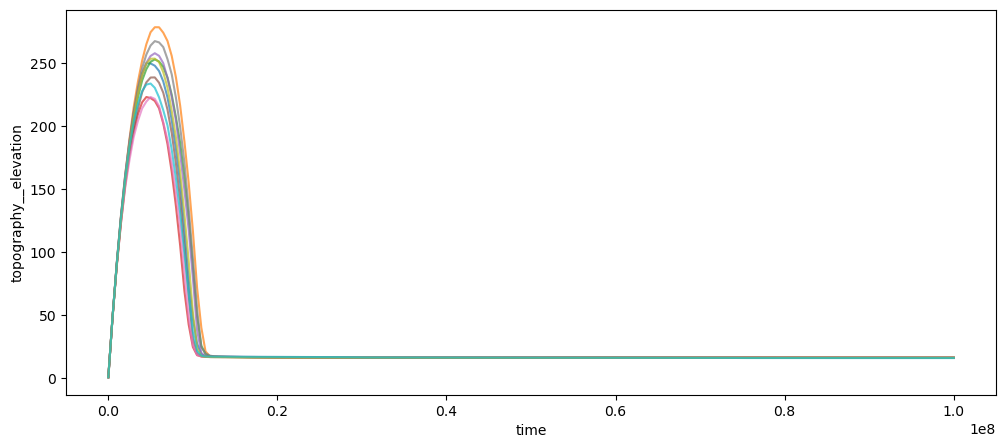

In [21]:
plt.figure(figsize=(12,5))
[run.topography__elevation.mean(("x", "y")).plot(alpha=0.7) for run in results_test]
plt.show()

Model topography has clearly reached steady-state after a balance and warm-up phase where the central area was not affected by channel-erosion

#### b) Topography

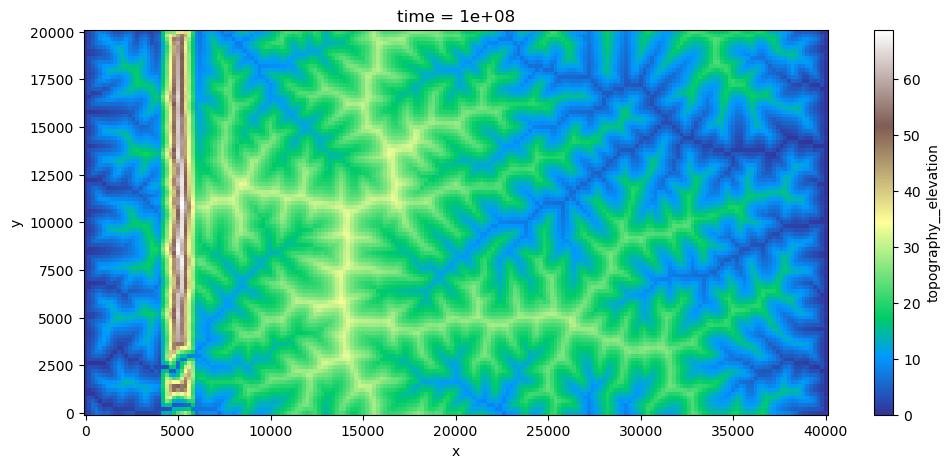

In [22]:
results_test[0].topography__elevation.isel(time=-1).plot(figsize=(12, 5), cmap="terrain", vmin=0)

Illustration of one particular simulation result. Here we can see the dyke which has only one large stream system that can cross it (starts east of the dyke but has it's sink in the west)

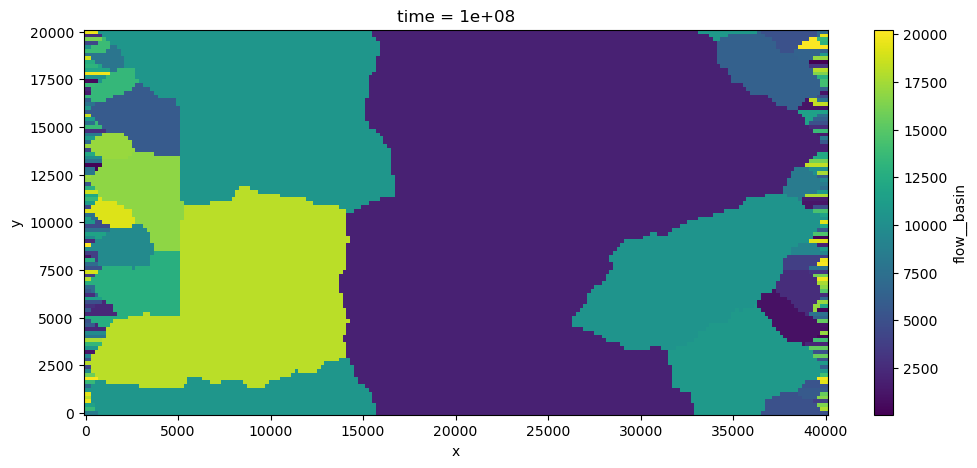

In [23]:
results_test[0].flow__basin.isel(time=-1).plot(figsize=(12, 5))

#### c) Corresponding graphs

In [24]:
SIM_Test = SIM_Bundler(results_list=results_test, ny=ny, nx=nx)
SIM_Test.fastscape2graphs(
    parallel=True,
    metrics=None,
    centres_by_run=10000,      # example dyke centre (grid col)
    centre_grid_nx=40001,      # 0..40000 → length 40001
    centre_mapping="extent"    # fit into observed [xmin..xmax]
)

# sanity: see midline stored by compute_outlets and x-extent
xext = graph_x_extent(SIM_Test.runs[0]["graphs"])
print("graph x extent:", xext, "| mid_x:", SIM_Test.runs[0].get("_mid_x"))

c:\Users\MS\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\networkx\linalg\laplacianmatrix.py:432: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  evals, evecs = sp.sparse.linalg.eigs(P.T, k=1)


graph x extent: (500000.0, 500200.0) | mid_x: None


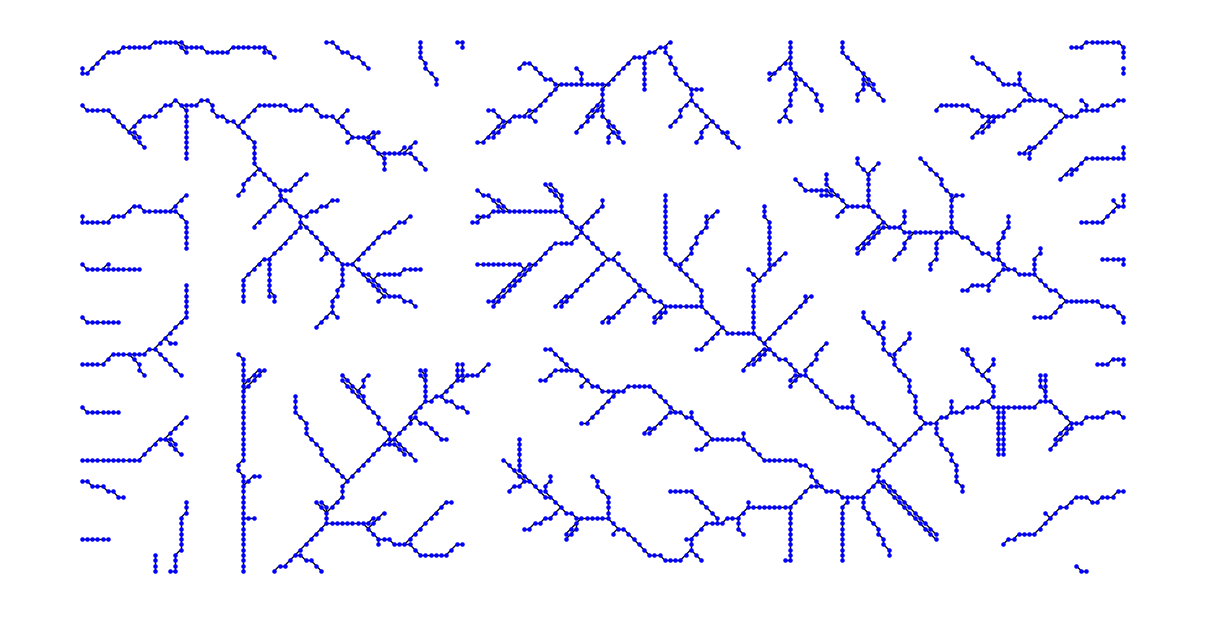

In [25]:
plt.figure(figsize=(12, 6))

for _, G in SIM_Test.runs[0]["graphs"].items():
    pos = {n: n for n in G.nodes}
    netx.draw(G, pos=pos, node_size=5, node_color="blue", arrows=False)

plt.show()

Same pattern visible here, rivers organize accoring to the initial topography and the dyke

#### d) Graph Metrics

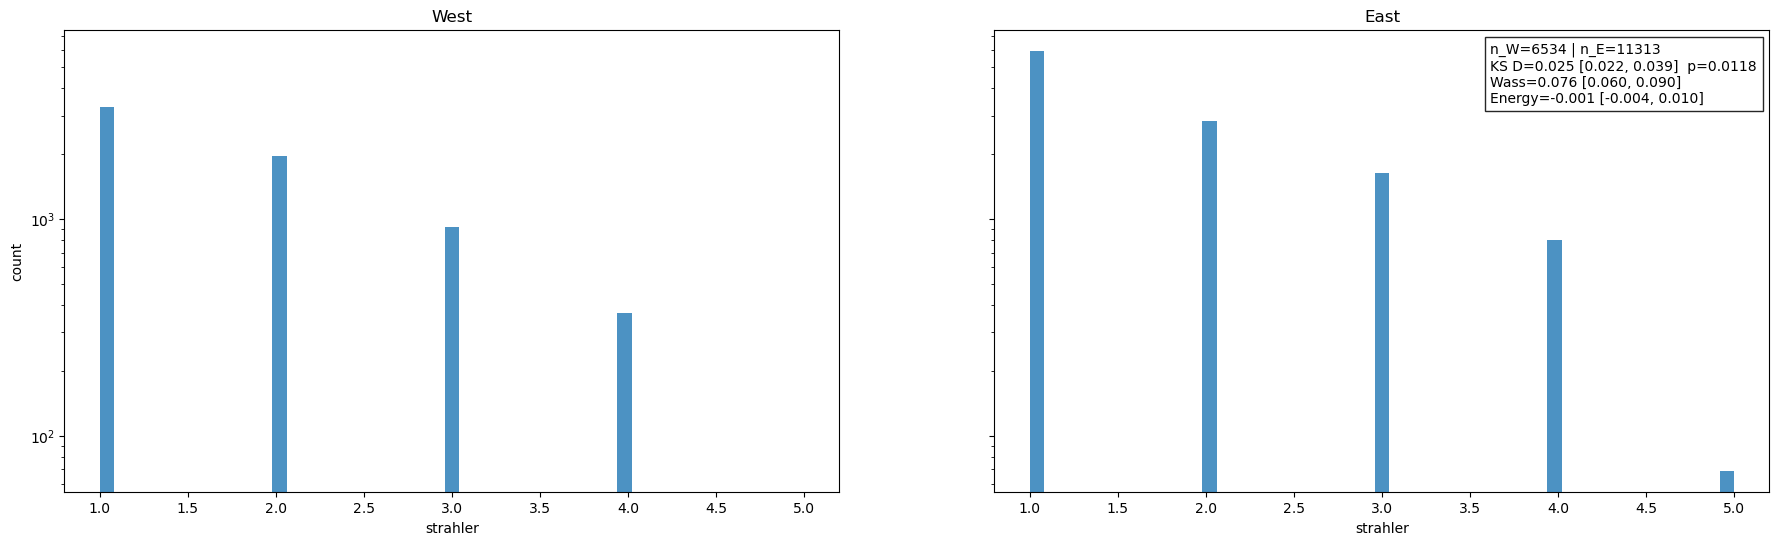

In [26]:
_ = metric_analysis(SIM=SIM_Test, metric='strahler', node_based=True, visualize=True, log=True, bin_num=50)

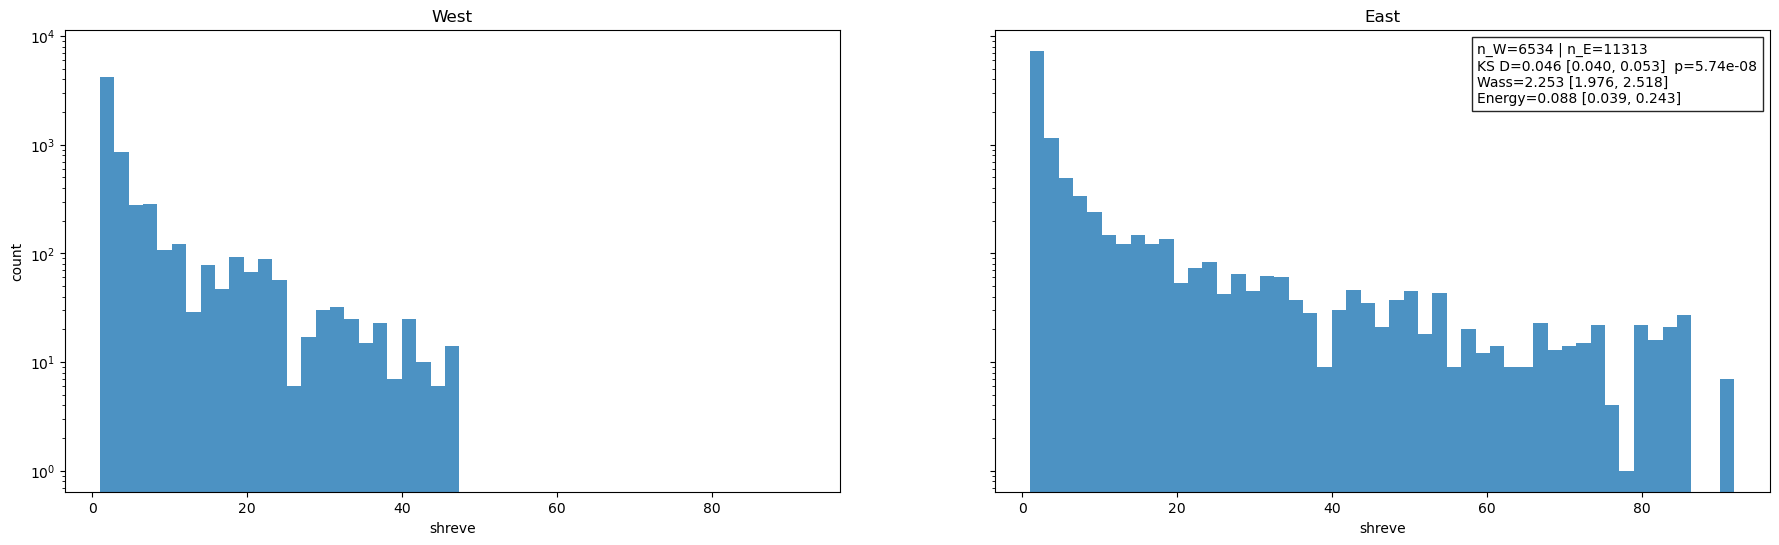

In [27]:
_ = metric_analysis(SIM=SIM_Test, metric='shreve', node_based=True, visualize=True, log=True, bin_num=50)

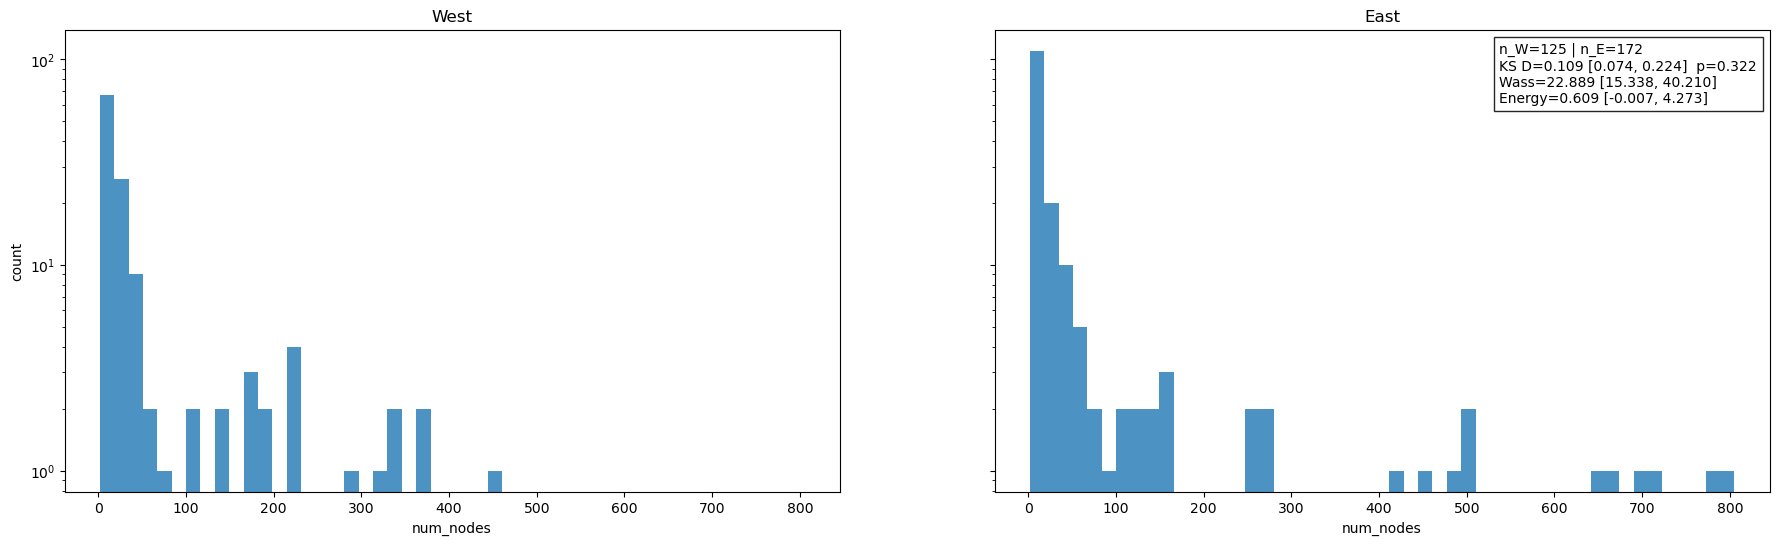

In [28]:
_ = metric_analysis(SIM=SIM_Test, metric='num_nodes', node_based=False, visualize=True, log=True, bin_num=50)

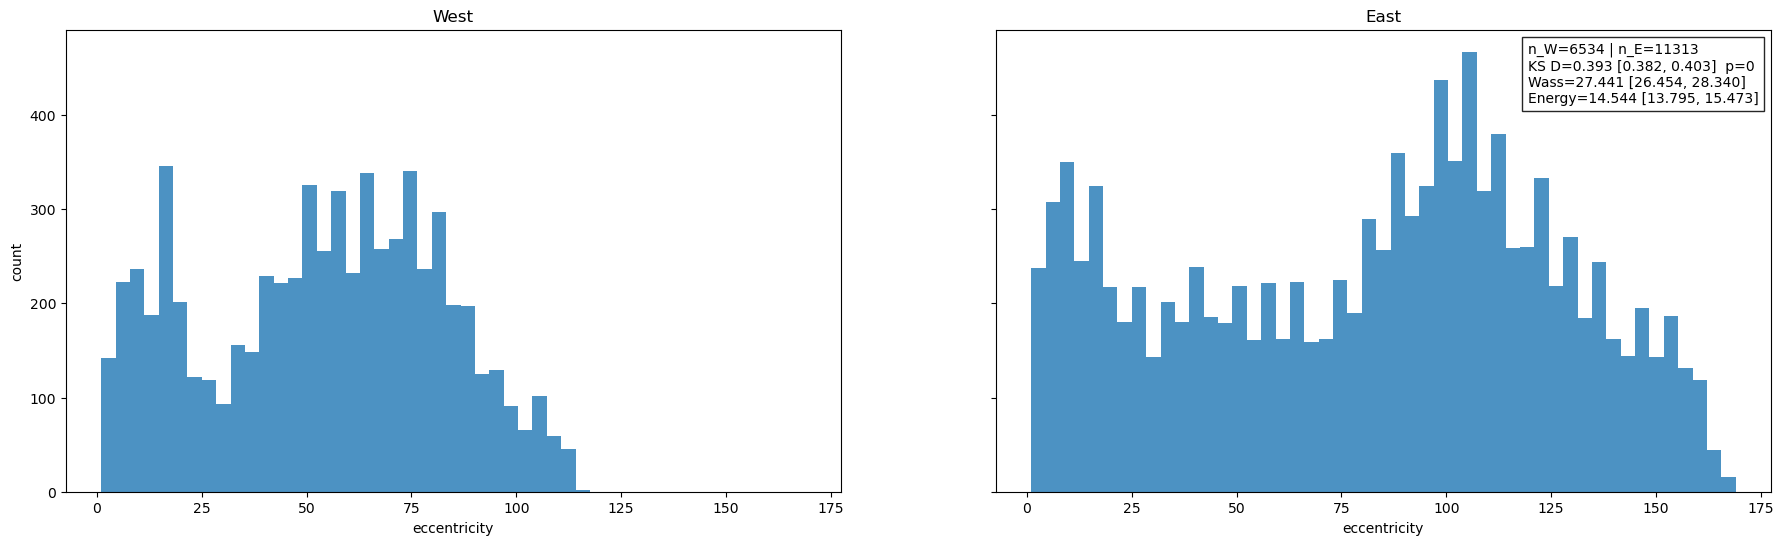

In [29]:
_ = metric_analysis(SIM=SIM_Test, metric='eccentricity', node_based=True, visualize=True, log=False, bin_num=50)

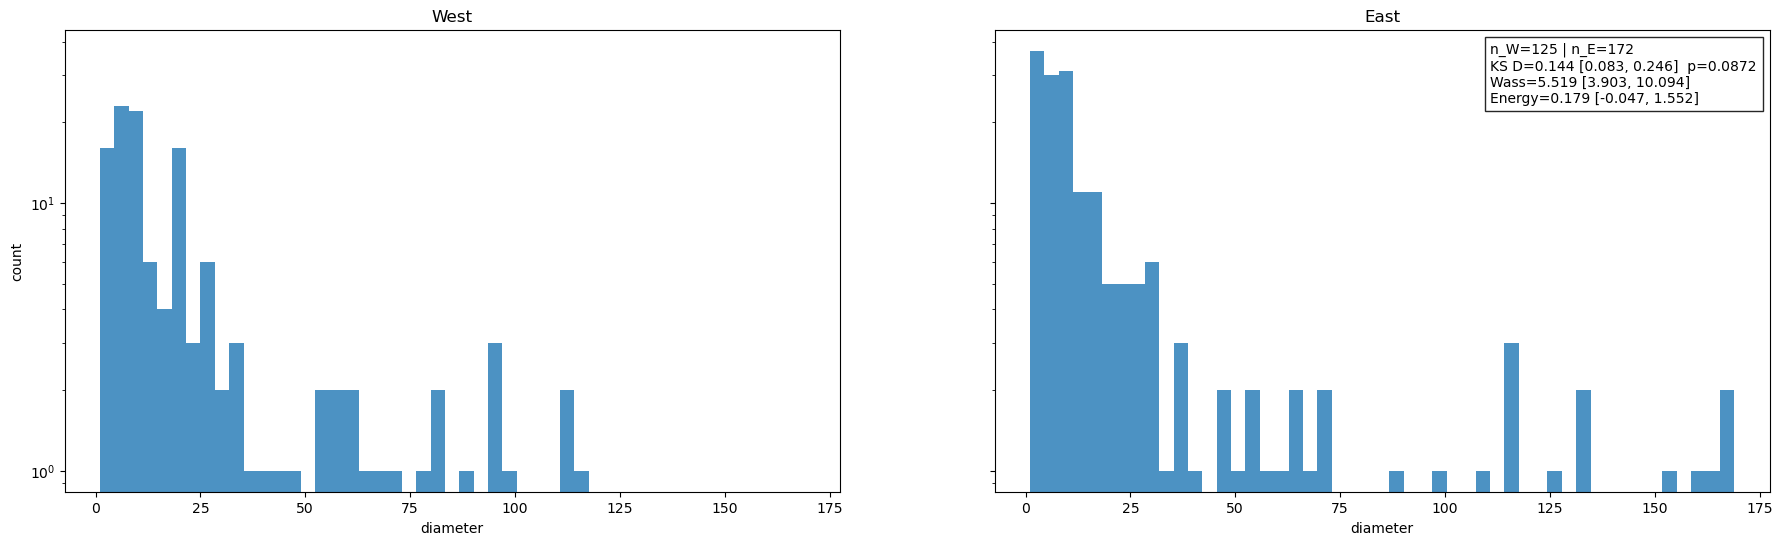

In [30]:
_ = metric_analysis(SIM=SIM_Test, metric='diameter', node_based=False, visualize=True, log=True, bin_num=50)

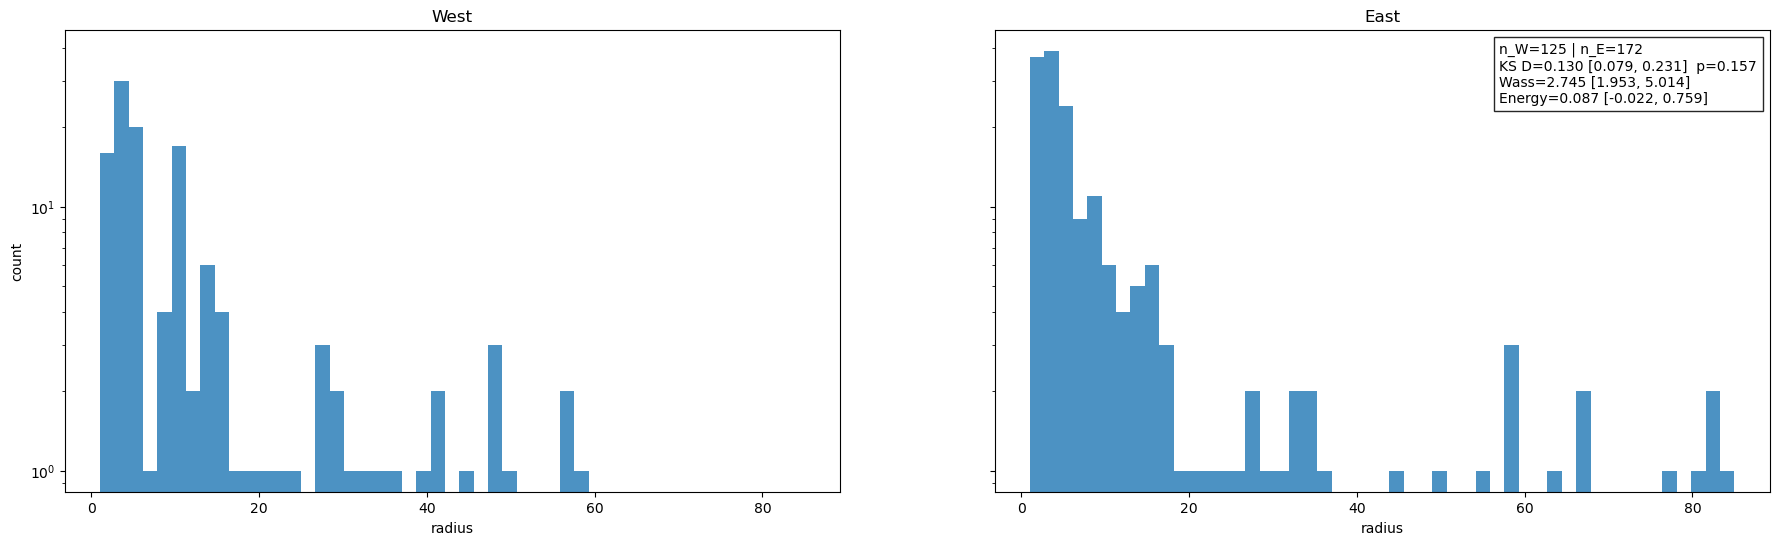

In [31]:
_ = metric_analysis(SIM=SIM_Test, metric='radius', node_based=False, visualize=True, log=True, bin_num=50)